In [1]:
import SoftRobots: draw

In [2]:
using ForwardDiff
import PyPlot
using NLopt
using Ipopt
using JuMP
using FixedSizeArrays
using ProfileView
using GeometryTypes
using LCMGL
import ForwardDiff: value

    +(Lazy.List...) at /Users/rdeits/.julia/v0.4/Lazy/src/Lazy.jl:24
is ambiguous with: 
    +(MultiPoly.MPoly...) at /Users/rdeits/.julia/v0.4/MultiPoly/src/mpolyarithmetic.jl:2.
To fix, define 
    +()
before the new definition.


In [3]:
reload("SpatialFields")
reload("SoftRobots")

In [3]:
Base.convert{T}(::Type{SoftRobots.SoftRobotState{T}}, x::Vector{T}) = SoftRobots.SoftRobotState(SoftRobots.Point{3, T}[x[i:i+2]
    for i in 1:3:(3*length(robot.nodes)-2)],
    [SoftRobots.Point{3, T}(0) for i in 1:length(robot.nodes)])
draw{T}(robot, x::Vector{T}) = draw(robot, convert(SoftRobots.SoftRobotState{T}, x))
value(x::Real) = x

value (generic function with 5 methods)

In [4]:
function tower()
    k = 10.
    b = 4.0
    l = 1.0
    m = 0.1
    nodes = SoftRobots.PointMass[]
    positions = SoftRobots.Point{3, Float64}[]
    
    for z = [1;2]
        x = 0
        y = 0
        push!(nodes, SoftRobots.PointMass(m))
        push!(positions, SoftRobots.Point{3, Float64}(x, y, z))
    end
    
    for z = 0:1:3
        bulge = 1 - 0.1*(z - 1.5)^2
        for x = -0.5:0.5
            for y = -0.5:0.5
                push!(nodes, SoftRobots.PointMass(m))
                push!(positions, SoftRobots.Point{3, Float64}(x*bulge, y*bulge, z))
            end
        end
    end
    for z in [-0.1; 3.1]
        for x in [-0.1; 0.1]
            for y in [-0.1; 0.1]
#     for (x,y,z) in Any[(0,0,-0.1), (0,0,3.1)]
                push!(nodes, SoftRobots.PointMass(m))
                push!(positions, SoftRobots.Point{3, Float64}(x, y, z))
            end
        end
    end
    

    num_nodes = length(nodes)
    edges = SoftRobots.DampedSpring[]
    for i = 1:num_nodes
        for j = (i+1):num_nodes
            rest_length = norm(positions[i] - positions[j])
            push!(edges, SoftRobots.DampedSpring(i, j, k, b, rest_length))
        end
    end
    faces = SoftRobots.convex_hull(positions)
    robot = SoftRobots.SoftRobot(nodes, edges, faces)
    velocities = [SoftRobots.Point{3, Float64}(0) for n in robot.nodes]
    state = SoftRobots.SoftRobotState(positions, velocities)
    robot, state
end
    
        

tower (generic function with 1 method)

In [5]:
robot, state = tower()
draw(robot, state)

 39

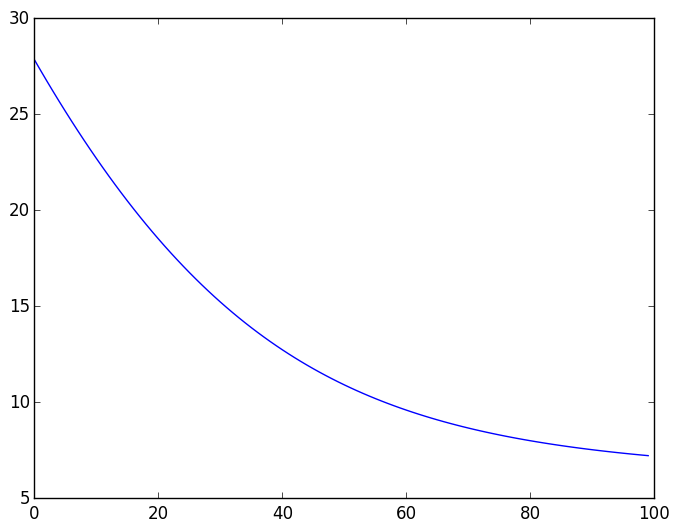

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325937710>

.843099 seconds (643.87 M allocations: 14.263 GB, 4.69% gc time)


In [7]:
# point = [0.0; 0.0; 2.5]
point = [0.25; 0; 2]

function potential_energy_fixed_base{T}(robot, state::SoftRobots.SoftRobotState{T})
    energy = zero(T)
    for edge in robot.edges
        energy += 0.5 * edge.stiffness * 
         (norm(state.positions[edge.parent] - state.positions[edge.child]) - 
          edge.rest_length)^2
    end
    for i = 1:2
        energy += 0.5 * 1000 * (state.positions[i][3]-(i))^2
    end
    
    energy
end

fd_states = []

function cost{T}(x::Vector{T})
    state = convert(SoftRobots.SoftRobotState{T}, x)
    energy = potential_energy_fixed_base(robot, state)
    push!(fd_states, state)
    SoftRobots.update_barrier!(robot, state)
    v = SoftRobots.evaluate(state.barrier, point)
    if any(isnan, v)
        @show v
        @show point
    end
    if v < 0
        energy += 0.5 * 100 * v^2
    end
    energy
end

x0 = collect(destructure(state.positions))
f = cost
g = ForwardDiff.gradient(f, ForwardDiff.AllResults)
x = copy(x0)
energies = []
step = 1e-4
# Profile.clear()
@time for i = 1:100
    gi, results = g(x)
    if any(isnan, gi)
        @show gi
        error("nan in gradient")
    end
    x -= step * gi
    draw(robot, map(value, x))
    
    state = convert(SoftRobots.SoftRobotState{Float64}, map(value, x))
    mesh = HomogenousMesh(state.positions, robot.faces)

    LCMGLClient("normals") do lcmgl
        normals = decompose(GeometryTypes.Normal{3, Float64}, mesh)
        color(lcmgl, 0,0,0)
        begin_mode(lcmgl, LCMGL.LINES)
        for i = 1:length(state.positions)
            vertex(lcmgl, state.positions[i]...)
            vertex(lcmgl, (state.positions[i] + Point(normals[i]))...)
        end
        end_mode(lcmgl)
        switch_buffer(lcmgl)
    end
    push!(energies, value(results))
end
# ProfileView.view()
PyPlot.plot(energies)
